In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!pip install --upgrade pip
!pip install kats
!pip install ax-platform==0.2.4 statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.3/950.3 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 25.3 MB/s eta 0:

In [4]:
import pandas as pd 
import numpy as np 
from kats.detectors.outlier import OutlierDetector
from kats.consts import TimeSeriesData
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.2
Num GPUs: 1


In [7]:
df = pd.read_csv("/content/gdrive/MyDrive/Maestría_CDA/2_SEMESTRE/Met_Estadísticos Avanzados /Proyecto Integrador/m5-forecasting-accuracy/Copia de total_sales_clean.csv")
df=df.drop(df.columns[[0]],axis=1)
df.head(5)

,date,state_id,cat_id,sell_price,value,total_sells
0,2011-01-29,CA,FOODS,4059.66,8878,36041661.48
1,2011-01-29,CA,HOBBIES,1470.28,1644,2417140.32
2,2011-01-29,CA,HOUSEHOLD,3594.69,2048,7361925.12
3,2011-01-30,CA,FOODS,3750.99,8593,32232257.07
4,2011-01-30,CA,HOBBIES,1334.13,1325,1767722.25


### **HOBBIES**


In [8]:
df_foods = df.query("cat_id == 'HOBBIES'").loc[:, ["date", "total_sells"]].set_index("date")
df_foods.head(3)

,total_sells
date,
2011-01-29,2417140.32
2011-01-30,1767722.25
2011-01-31,1467471.06


In [9]:
np.max(df_foods.total_sells)

9114651.52

In [10]:
# Se utiliza la librería kats para identificar e interpolar los outiliers
ts = TimeSeriesData(df.query("cat_id == 'FOODS'").loc[:, ["date", "total_sells"]].rename(columns={"date":"time"}))
outlier_detector = OutlierDetector(ts, "additive")
outlier_detector.detector()
outliers = outlier_detector.outliers
ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)

df_foods = ts_day_outliers_interpolated.to_dataframe()

df_foods.columns =["date", "total_sells"]
df_foods.set_index("date", inplace=True)
df_foods.sort_index()
df_foods.sort_index(inplace=True)
df_foods.head()

,total_sells
date,
2011-01-29,36041661.48
2011-01-30,32232257.07
2011-01-31,19527808.56
2011-02-01,22887926.52
2011-02-02,19278399.79


In [11]:
ind = df_foods.total_sells < 1000
df_foods[ind]

,total_sells
date,
2012-12-25,81.18


In [12]:
df_foods.loc[ind, "total_sells"] = df_foods.median().values[0]

In [13]:
df_foods["log"] = np.log(df_foods.total_sells.values)
df_foods["diff_log"] = df_foods.log.diff()

In [14]:
df_foods.dropna(inplace=True)

In [15]:
df_foods.head()

,total_sells,log,diff_log
date,,,
2011-01-30,32232257.07,17.288478,-0.111708
2011-01-31,19527808.56,16.787350,-0.501128
2011-02-01,22887926.52,16.946120,0.158770
2011-02-02,19278399.79,16.774496,-0.171624
2011-02-03,24558648.01,17.016575,0.242079


In [16]:
np.max(df_foods.total_sells)

123949968.93

In [17]:
df_foods_ori = df_foods
df_foods_test_hold = df_foods.iloc[-60:,:]
df_foods = df_foods.iloc[:-60,:]
df_foods.shape

(1880, 3)

In [18]:
data = df_foods.total_sells.copy()

# Get the number of rows in the data
nrows = df_foods.shape[0]

# Convert the data to numpy values
np_data_unscaled = df_foods.total_sells.values
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = StandardScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 180

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.99)

# Create the training and test data
train_data = np_data_scaled[:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]


(1880, 1)


In [19]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(1682, 180, 1) (1682,)
(18, 180, 1) (18,)
2.6375424321350693
2.6375424321350693


In [20]:
epochs = 21; batch_size = 1;

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
model = Sequential()
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

In [31]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/21
1513/1513 [==============================] - 21s 14ms/step - loss: 0.1252 - val_loss: 0.2553
Epoch 2/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1203 - val_loss: 0.4941
Epoch 3/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1171 - val_loss: 0.3064
Epoch 4/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1134 - val_loss: 0.2540
Epoch 5/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1069 - val_loss: 0.2378
Epoch 6/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1061 - val_loss: 0.2704
Epoch 7/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1003 - val_loss: 0.2521
Epoch 8/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.0991 - val_loss: 0.3767
Epoch 9/21
1513/1513 [==============================] - 20s 13ms/step - loss: 0.1024 - val_loss: 0.2548
Epoch 10/21
1513/1513 [==============================] - 20s 13m

In [32]:
# Reshape the data, so that we get an array with multiple test datasets
x_test_np = np.array(x_test)
x_test_reshape = np.reshape(x_test_np, (x_test_np.shape[0], x_test_np.shape[1], 1))

# Get the predicted values
y_pred = model.predict(x_test_reshape)
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

1/1 [==============================] - 0s 25ms/step
Median Absolute Error (MAE): 7073574.64
Mean Absolute Percentage Error (MAPE): 9.42 %
Median Absolute Percentage Error (MDAPE): 7.3 %


In [33]:
x_train.shape

(1682, 180, 1)

In [34]:
df_foods["y_pred"] = np.nan

<ipython-input-34-b0413f6780da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foods["y_pred"] = np.nan


In [35]:
y_pred_unscaled = pd.Series(y_pred_unscaled.flatten())

In [36]:
df_foods.iloc[-y_pred_unscaled.shape[0]:, -1] = y_pred_unscaled

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [37]:
df_foods.tail()

,total_sells,log,diff_log,y_pred
date,,,,
2016-03-19,80225792.35,18.200356,0.155454,94200816.0
2016-03-20,74614901.82,18.127851,-0.072505,76998200.0
2016-03-21,67282749.50,18.024414,-0.103436,71633648.0
2016-03-22,63954099.56,17.973676,-0.050738,52114976.0
2016-03-23,61200862.74,17.929672,-0.044004,59168652.0


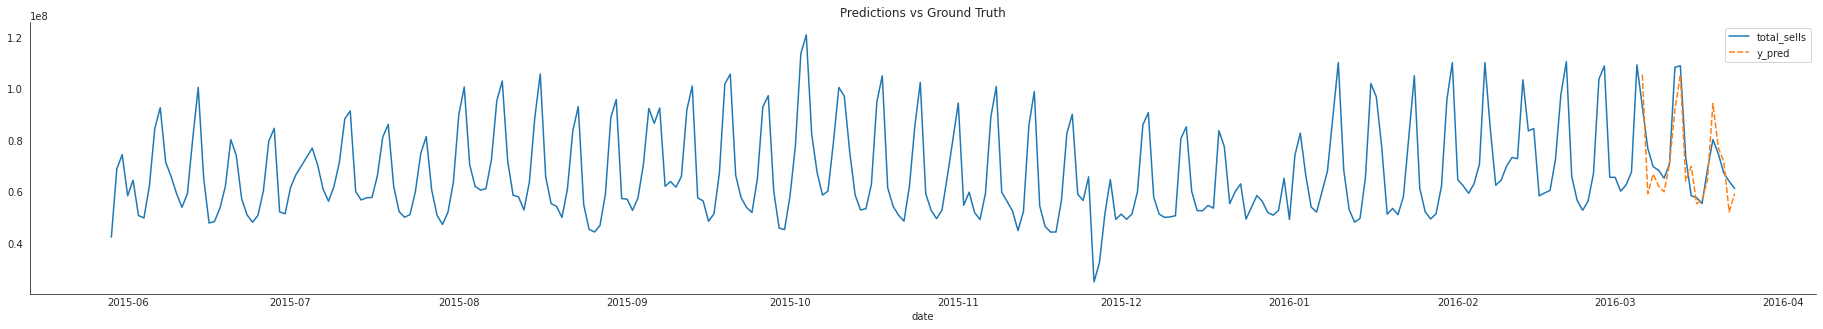

In [38]:
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(32, 5), sharex=True)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth")
sns.lineplot(data=df_foods[["total_sells", "y_pred"]].iloc[-300:,:])
plt.show()

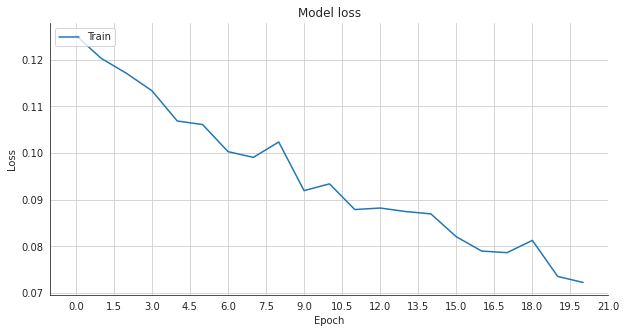

In [44]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
sns.lineplot(data=history.history["loss"])

plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

#### **Multi-step**

In [45]:
# Settings and Model Labels
rolling_forecast_range = 30
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", n_neurons],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Making a Multi-Step Prediction
# Create the initial input data
new_df = df_foods.filter(["total_sells"])
for i in range(0, rolling_forecast_range):
    # Select the last sequence from the dataframe as input for the prediction model
    last_values = new_df[-n_neurons:].values
    
    # Scale the input data and bring it into shape
    last_values_scaled = scaler.transform(last_values)
    X_input = np.array(last_values_scaled).reshape([1, 180, 1])
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    
    # Predict and unscale the predictions
    pred_value = model.predict(X_input)
    pred_value_unscaled = scaler.inverse_transform(pred_value)
    
    # Add the prediction to the next input dataframe
    new_df = pd.concat([new_df, pd.DataFrame({"total_sells": pred_value_unscaled[0, 0]}, index=new_df.iloc[[-1]].index.values + 1)])
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"total_sells": "Forecast"}
)

1/1 [==============================] - 0s 19ms/step


In [46]:
df_foods.tail()

,total_sells,log,diff_log,y_pred
date,,,,
2016-03-19,80225792.35,18.200356,0.155454,94200816.0
2016-03-20,74614901.82,18.127851,-0.072505,76998200.0
2016-03-21,67282749.50,18.024414,-0.103436,71633648.0
2016-03-22,63954099.56,17.973676,-0.050738,52114976.0
2016-03-23,61200862.74,17.929672,-0.044004,59168652.0


In [47]:
yval = df_foods_test_hold.iloc[:30,:][["total_sells"]]
yval["y_pred"] = forecast.values

In [48]:
# Mean Absolute Error (MAE)
y_test_unscaled, y_pred_unscaled = yval.total_sells.values, yval.y_pred.values

MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 9484482.28
Mean Absolute Percentage Error (MAPE): 11.74 %
Median Absolute Percentage Error (MDAPE): 10.11 %


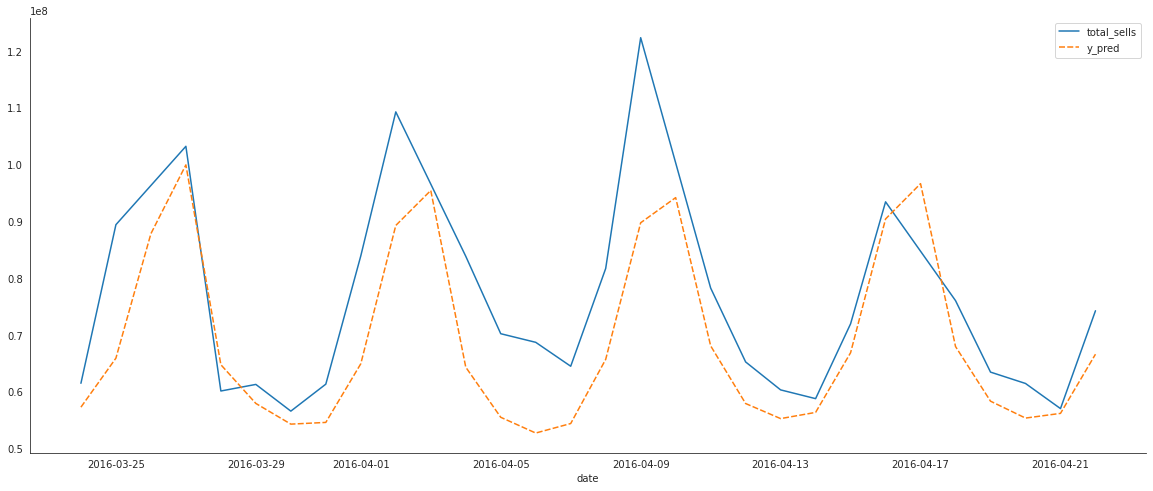

In [49]:
plt.figure(figsize=(20,8))
plt.tight_layout
sns.lineplot(data=yval)


**Se re-entrena con todo el dataset y se prueba en test**

In [50]:
df_foods = df_foods_ori 
df_foods_test_hold = df_foods.iloc[-30:,:]
df_foods = df_foods.iloc[:-30,:]


#---------------------------------------------------------------------
data = df_foods.total_sells.copy()

# Get the number of rows in the data
nrows = df_foods.shape[0]

# Convert the data to numpy values
np_data_unscaled = df_foods.total_sells.values
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = StandardScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 180

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.99)

# Create the training and test data
train_data = np_data_scaled[:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

#------------------------------------------------------------------------------------------

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])


(1910, 1)
(1711, 180, 1) (1711,)
(19, 180, 1) (19,)
2.046284571189935
2.046284571189935


In [51]:
epochs = 20; batch_size = 1;

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
model = Sequential()
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

In [52]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
1711/1711 [==============================] - 24s 13ms/step - loss: 0.3834
Epoch 2/20
1711/1711 [==============================] - 21s 12ms/step - loss: 0.1663
Epoch 3/20
1711/1711 [==============================] - 21s 12ms/step - loss: 0.1668
Epoch 4/20
1711/1711 [==============================] - 21s 12ms/step - loss: 0.1522
Epoch 5/20
1711/1711 [==============================] - 21s 12ms/step - loss: 0.1442
Epoch 6/20
1711/1711 [==============================] - 21s 12ms/step - loss: 0.1306
Epoch 7/20
1711/1711 [==============================] - 21s 12ms/step - loss: 0.1280
Epoch 8/20
1711/1711 [==============================] - 21s 13ms/step - loss: 0.1177
Epoch 9/20
1711/1711 [==============================] - 21s 13ms/step - loss: 0.1127
Epoch 10/20
1711/1711 [==============================] - 22s 13ms/step - loss: 0.5415
Epoch 11/20
1711/1711 [==============================] - 22s 13ms/step - loss: 0.2995
Epoch 12/20
1711/1711 [==============================] - 22s 13

In [54]:
# Reshape the data, so that we get an array with multiple test datasets
x_test_np = np.array(x_test)
x_test_reshape = np.reshape(x_test_np, (x_test_np.shape[0], x_test_np.shape[1], 1))

# Get the predicted values
y_pred = model.predict(x_test_reshape)
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

1/1 [==============================] - 0s 25ms/step
Median Absolute Error (MAE): 6255130.81
Mean Absolute Percentage Error (MAPE): 7.64 %
Median Absolute Percentage Error (MDAPE): 6.94 %


In [55]:
# Settings and Model Labels
rolling_forecast_range = 30
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", n_neurons],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Making a Multi-Step Prediction
# Create the initial input data
new_df = df_foods.filter(["total_sells"])
for i in range(0, rolling_forecast_range):
    # Select the last sequence from the dataframe as input for the prediction model
    last_values = new_df[-n_neurons:].values
    
    # Scale the input data and bring it into shape
    last_values_scaled = scaler.transform(last_values)
    X_input = np.array(last_values_scaled).reshape([1, 180, 1])
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    
    # Predict and unscale the predictions
    pred_value = model.predict(X_input)
    pred_value_unscaled = scaler.inverse_transform(pred_value)
    
    # Add the prediction to the next input dataframe
    new_df = pd.concat([new_df, pd.DataFrame({"total_sells": pred_value_unscaled[0, 0]}, index=new_df.iloc[[-1]].index.values + 1)])
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"total_sells": "Forecast"}
)

1/1 [==============================] - 0s 19ms/step


In [56]:
df_foods_test_hold.shape

(30, 3)

In [57]:
yval = df_foods_test_hold.iloc[:30,:][["total_sells"]]
yval["y_pred"] = forecast.values

In [58]:
# Mean Absolute Error (MAE)
y_test_unscaled, y_pred_unscaled = yval.total_sells.values, yval.y_pred.values

MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 12138496.66
Mean Absolute Percentage Error (MAPE): 13.7 %
Median Absolute Percentage Error (MDAPE): 13.41 %


In [59]:
mean_absolute_error(y_test_unscaled, y_pred_unscaled )
mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled )

0.1369794427446912

In [60]:
np.max(y_test_unscaled)

123949968.93

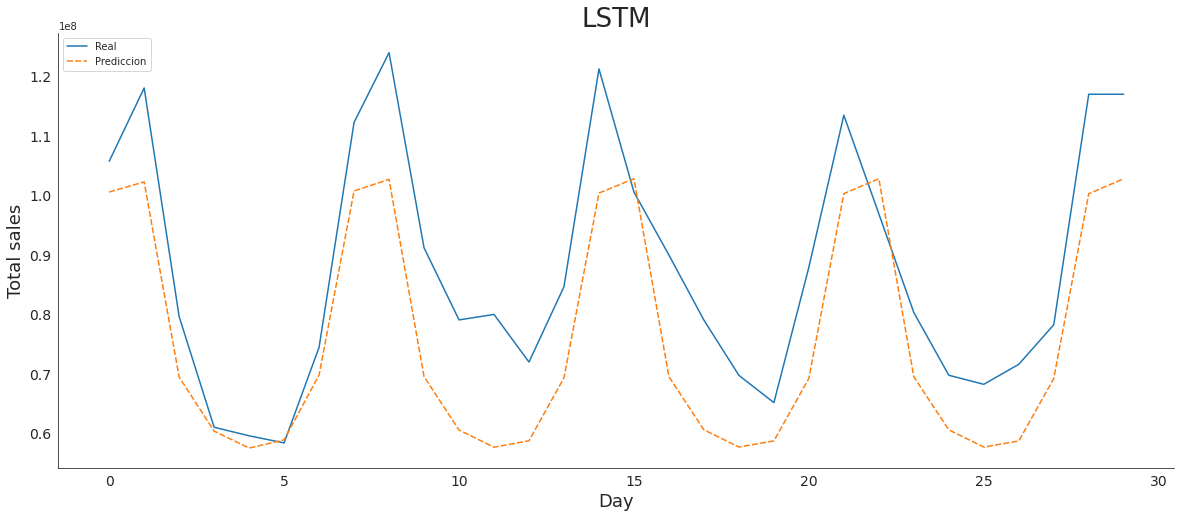

In [82]:


plt.figure(figsize=(20,8))
plt.tight_layout
plt.title("LSTM", size=26)
sns.lineplot(data=yval.reset_index(drop=True))
plt.ylabel("Total sales", size=18)
plt.xlabel("Day", size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(labels=["Real", "Prediccion"], loc = 'upper left');
